# K-Nearest Neighbours using IRIS dataset 

## Step 0: Load required libraries 

In [1]:
import pandas as pd
import numpy as np
import math
from random import seed
from random import randrange
import matplotlib.pyplot as plt

## Step 1: Load the data set

In [2]:
data_set = pd.read_csv('dataset/iris.data',header=None)
data_set.columns = ['sepal_length','sepal_width','petal_length','petal_width','class']
print(data_set.head())

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


## Step 2: Euclidean distance implementation

In [3]:
#  distance calculating methods
#  Euclidean_distance
def vector_euclideanDistance(input_data, training_data):
    # copy the training data set
    training_data = training_data.copy()
    # drop the class column
    training_data = training_data.iloc[:, :-1]
    # convert to numpy array
    training_data = training_data.to_numpy()
    test_data = np.repeat([input_data],training_data.shape[0],axis=0)
    distance = np.sqrt(np.sum((test_data-training_data)**2,axis=1))
    return distance

## Step 3: Cosine Similarity implementation 

In [4]:
#  Cosine_distance
def vector_cosineDistance(input_data, training_data):
    # copy the training data set
    training_data = training_data.copy()
    # drop the class column
    training_data = training_data.iloc[:, :-1]
    # convert to numpy array
    training_data = training_data.to_numpy()
    dot_product = np.sum(np.multiply(training_data,input_data),axis = 1)
    norm_training = np.sum(np.abs(training_data)**2,axis=-1)**(1./2)
    norm_test = np.repeat([np.sum(np.abs(input_data)**2,axis=-1)**(1./2)],training_data.shape[0],axis=0)
    similarity = dot_product/np.multiply(norm_training,norm_test)
    distance = np.abs(np.subtract(similarity,1))
    return distance

## Step 4: Method to get K nearest neighbour 

In [5]:
#  function to get k-neighbors
def getKNeighbors(input_data,train_data_set,num_neighbors,distance_metric):
    distance_dict = {}
    distance_np_array = []
    if distance_metric == 'norm_euclideanDistance' or distance_metric == 'vector_euclideanDistance':
        distance_np_array = vector_euclideanDistance(input_data, train_data_set)
    elif distance_metric == 'vector_cosineDistance':
        distance_np_array = vector_cosineDistance(input_data, train_data_set)
    else:
        raise Exception('No such distance metric implemented')
    for i in range(distance_np_array.shape[0]):
        distance_dict[i] = distance_np_array[i]
    distance_dict = sorted(distance_dict.items(),key=lambda item: item[1])
    return distance_dict[0:num_neighbors]

## Step 5: Method to predict the class based on K-NN

In [6]:
#  predicting the class based on max occurence of a class
def max_count_makePrediction(train_data_set, input_data, num_of_neighbors,distance_metric):
    k_neighbors = getKNeighbors(input_data,train_data_set,num_of_neighbors,distance_metric)
    k_neighbors_class = []
    for example in k_neighbors:
        row_of_example = train_data_set.iloc[example[0],train_data_set.shape[1]-1]
        k_neighbors_class.append(row_of_example)
    count_of_class = {k:k_neighbors_class.count(k) for k in set(k_neighbors_class)}
    predicted_class = max(count_of_class)
    return predicted_class

## Step 6: Performance Evaluation Section 

In [7]:
# Split a dataset into test and development
def validation_split(dataset, ratio = 0.2):
    dataset_index_list = list(range(len(dataset)))
    split_size = int(len(dataset) * ratio)
    test_data_index = list()
    dev_test_data_index = list()
    for _ in range(split_size):
        index = randrange(len(dataset_index_list))
        dataset_index_list.pop(index)
        test_data_index.append(index)
    for _ in range(split_size):
        index = randrange(len(dataset_index_list))
        dataset_index_list.pop(index)
        dev_test_data_index.append(index)
    
    test_dataset = dataset.iloc[test_data_index]
    test_dataset.columns = ['sepal_length','sepal_width','petal_length','petal_width','class']
    dev_test_dataset = dataset.iloc[dev_test_data_index]
    dev_test_dataset.columns = ['sepal_length','sepal_width','petal_length','petal_width','class']
    dev_dataset = dataset.iloc[dataset_index_list]
    dev_dataset.columns = ['sepal_length','sepal_width','petal_length','petal_width','class']
    return (test_dataset,dev_dataset,dev_test_dataset)

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def k_nearest_neighbors_max_count(train, test, num_neighbors,distance_metric):
    predictions = list()
    for row in test:
        output = max_count_makePrediction(train, row, num_neighbors,distance_metric)
        predictions.append(output)
    return(predictions)

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, ratio, num_neighbors,distance_metric):
    if distance_metric == 'norm_euclideanDistance':
        dataset.iloc[:,:-1] = (dataset.iloc[:,:-1] - dataset.iloc[:,:-1].min()) / (dataset.iloc[:,:-1].max() - dataset.iloc[:,:-1].min())
    test_split,dev_split,dev_test_split = validation_split(dataset, ratio)
    
    # drop the class column data of dev set for validation
    actual = dev_test_split.iloc[:,-1].to_list()
    dev_test_split = dev_test_split.iloc[:,:-1]
    dev_test_split = dev_test_split.to_numpy()
    dev_test_split = dev_test_split.tolist()
    predicted = (algorithm(dev_split, dev_test_split, num_neighbors,distance_metric))
    accuracy = accuracy_metric(actual, predicted)
    scores_train = accuracy
    
    # drop the class column data of test set
    actual = test_split.iloc[:,-1].to_list()
    test_split = test_split.iloc[:,:-1]
    test_split = test_split.to_numpy()
    test_split = test_split.tolist()
    predicted = (algorithm(dev_split, test_split, num_neighbors,distance_metric))
    accuracy = accuracy_metric(actual, predicted)
    scores_test = accuracy
    return (scores_train,scores_test)


# evaluate algorithm
seed(1)

# change the number of ratio in split
ratio = 0.2

# Adjust the Hyper parameters

## change the number of neighbors in K-NN.
##### num_neighbors = 1

## change the distance metric
## choose from: 
##### euclidean distance = vector_euclideanDistance
##### normalized euclidean distance = norm_euclideanDistance
##### cosine similarity = vector_cosineDistance

## c. Using the development dataset,
- Calculate accuracy by iterating all of the development data point

In [8]:
# Hyper params
num_neighbors = [1,3,5,7]
distance_metric = ['vector_euclideanDistance','norm_euclideanDistance','vector_cosineDistance']
dev_score_plot = []
test_score_plot = []

for dist in distance_metric:
    for num_neighbor in num_neighbors:
        dev_score,test_score = evaluate_algorithm(data_set, k_nearest_neighbors_max_count, ratio, num_neighbor,dist)
        print('-'*30)
        print(f'Evaluation of {num_neighbor} - Nearest Neighbor(kNN - using max count to classify) algorithm using {ratio*100}% split dev v/s test')
        print('Distance metric used: ',dist)
        print('Accuracy score for development data: %.3f%%' % dev_score)
        print('Accuracy score for testing data: %.3f%%' % test_score)
        print('-'*30)
        dev_score_plot.append(dev_score)
        test_score_plot.append(test_score)

------------------------------
Evaluation of 1 - Nearest Neighbor(kNN - using max count to classify) algorithm using 20.0% split dev v/s test
Distance metric used:  vector_euclideanDistance
Accuracy score for development data: 96.667%
Accuracy score for testing data: 96.667%
------------------------------
------------------------------
Evaluation of 3 - Nearest Neighbor(kNN - using max count to classify) algorithm using 20.0% split dev v/s test
Distance metric used:  vector_euclideanDistance
Accuracy score for development data: 93.333%
Accuracy score for testing data: 96.667%
------------------------------
------------------------------
Evaluation of 5 - Nearest Neighbor(kNN - using max count to classify) algorithm using 20.0% split dev v/s test
Distance metric used:  vector_euclideanDistance
Accuracy score for development data: 100.000%
Accuracy score for testing data: 93.333%
------------------------------
------------------------------
Evaluation of 7 - Nearest Neighbor(kNN - using 

## c. Draw bar charts for accuracy 

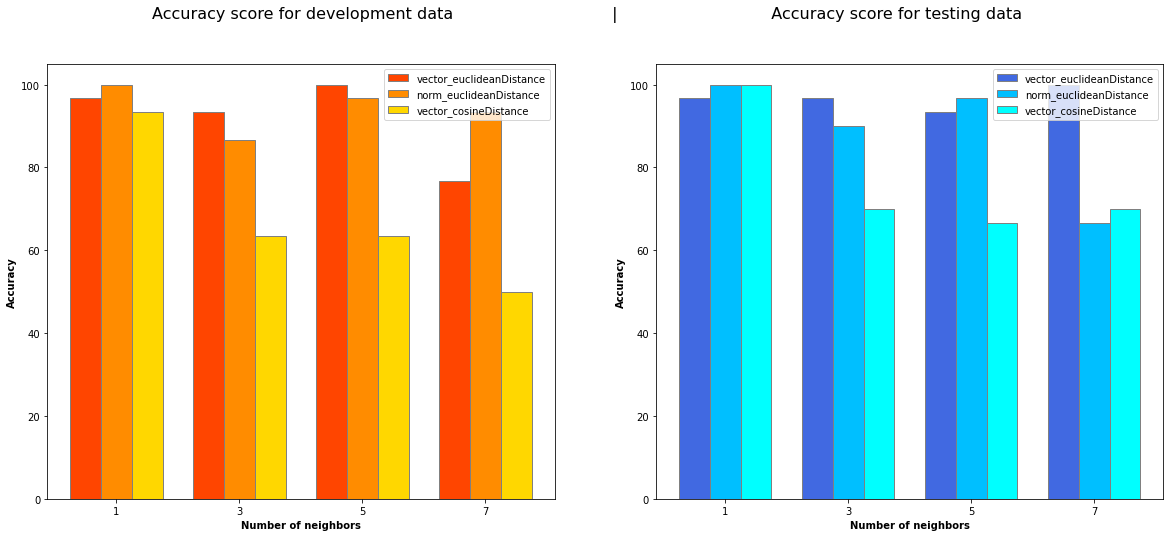

In [9]:
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(20, 8))
   
# set height of bar 
VED = dev_score_plot[0:4] 
NED = dev_score_plot[4:8]
VCD = dev_score_plot[8:12] 
   
# Set position of bar on X axis 
br1 = np.arange(len(VED)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

plt.subplot(1,2,1)
# Make the plot 
plt.bar(br1, VED, color ='orangered', width = barWidth, 
        edgecolor ='grey', label = distance_metric[0]) 
plt.bar(br2, NED, color ='darkorange', width = barWidth, 
        edgecolor ='grey', label = distance_metric[1]) 
plt.bar(br3, VCD, color ='gold', width = barWidth, 
        edgecolor ='grey', label = distance_metric[2]) 
   
# Adding Xticks  
plt.xlabel('Number of neighbors', fontweight ='bold') 
plt.ylabel('Accuracy', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(VED))],num_neighbors) 
plt.legend()

# set height of bar 
VED = test_score_plot[0:4] 
NED = test_score_plot[4:8]
VCD = test_score_plot[8:12] 
   
# Set position of bar on X axis 
br1 = np.arange(len(VED)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

plt.subplot(1,2,2)
# Make the plot 
plt.bar(br1, VED, color ='royalblue', width = barWidth, 
        edgecolor ='grey', label = distance_metric[0]) 
plt.bar(br2, NED, color ='deepskyblue', width = barWidth, 
        edgecolor ='grey', label = distance_metric[1]) 
plt.bar(br3, VCD, color ='cyan', width = barWidth, 
        edgecolor ='grey', label = distance_metric[2]) 
   
# Adding Xticks  
plt.xlabel('Number of neighbors', fontweight ='bold') 
plt.ylabel('Accuracy', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(VED))],num_neighbors) 
plt.legend()
plt.suptitle('Accuracy score for development data '+' '*30+'|'+' '*30+'Accuracy score for testing data', fontsize=16)
plt.show()

## c. Find optimal hyperparameters

In [10]:
# Hyper params
num_neighbors = list(range(1,151))
distance_metric = ['vector_euclideanDistance','norm_euclideanDistance','vector_cosineDistance']
dev_score_plot = []
test_score_plot = []

for dist in distance_metric:
    for num_neighbor in num_neighbors:
        dev_score,test_score = evaluate_algorithm(data_set, k_nearest_neighbors_max_count, ratio, num_neighbor,dist)
        dev_score_plot.append(dev_score)
        test_score_plot.append(test_score)

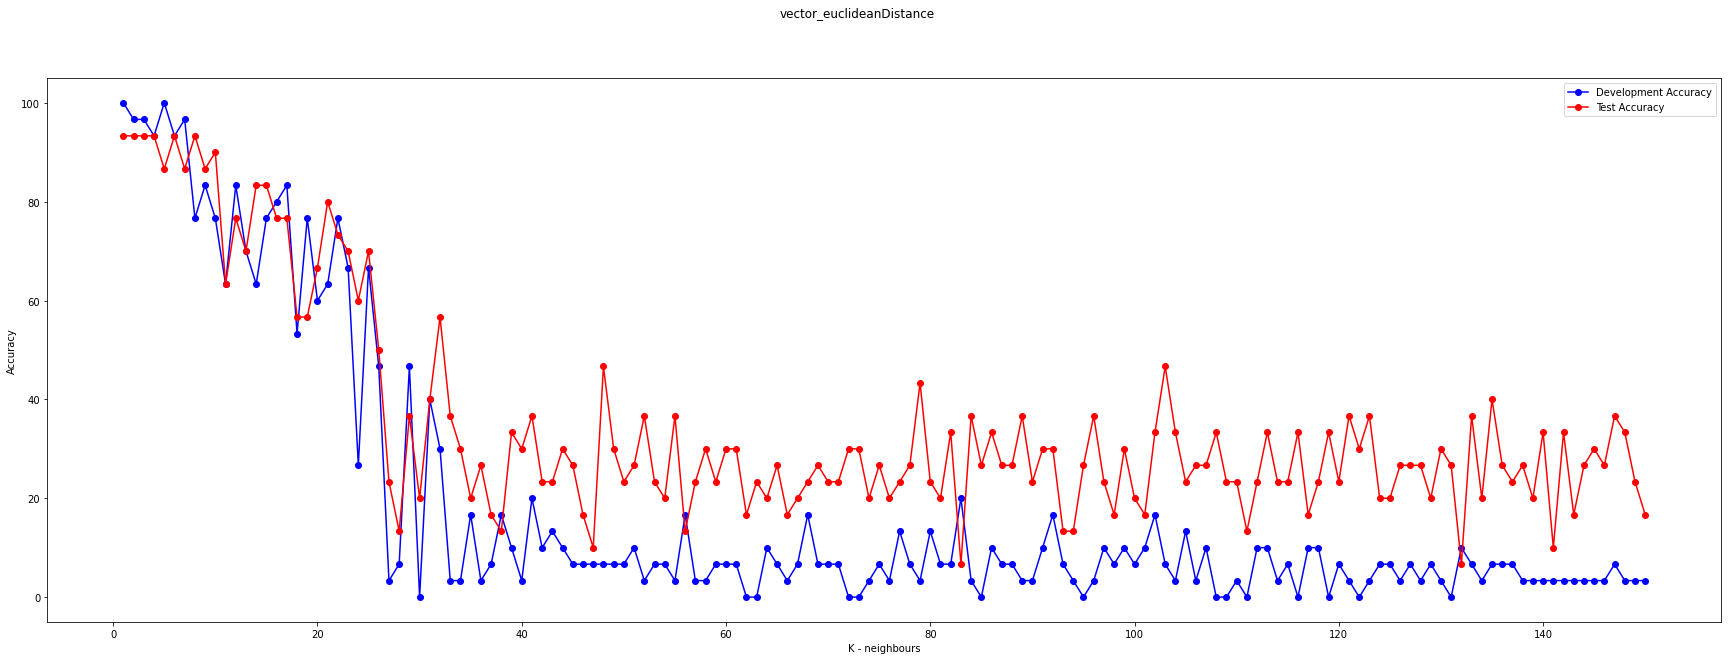

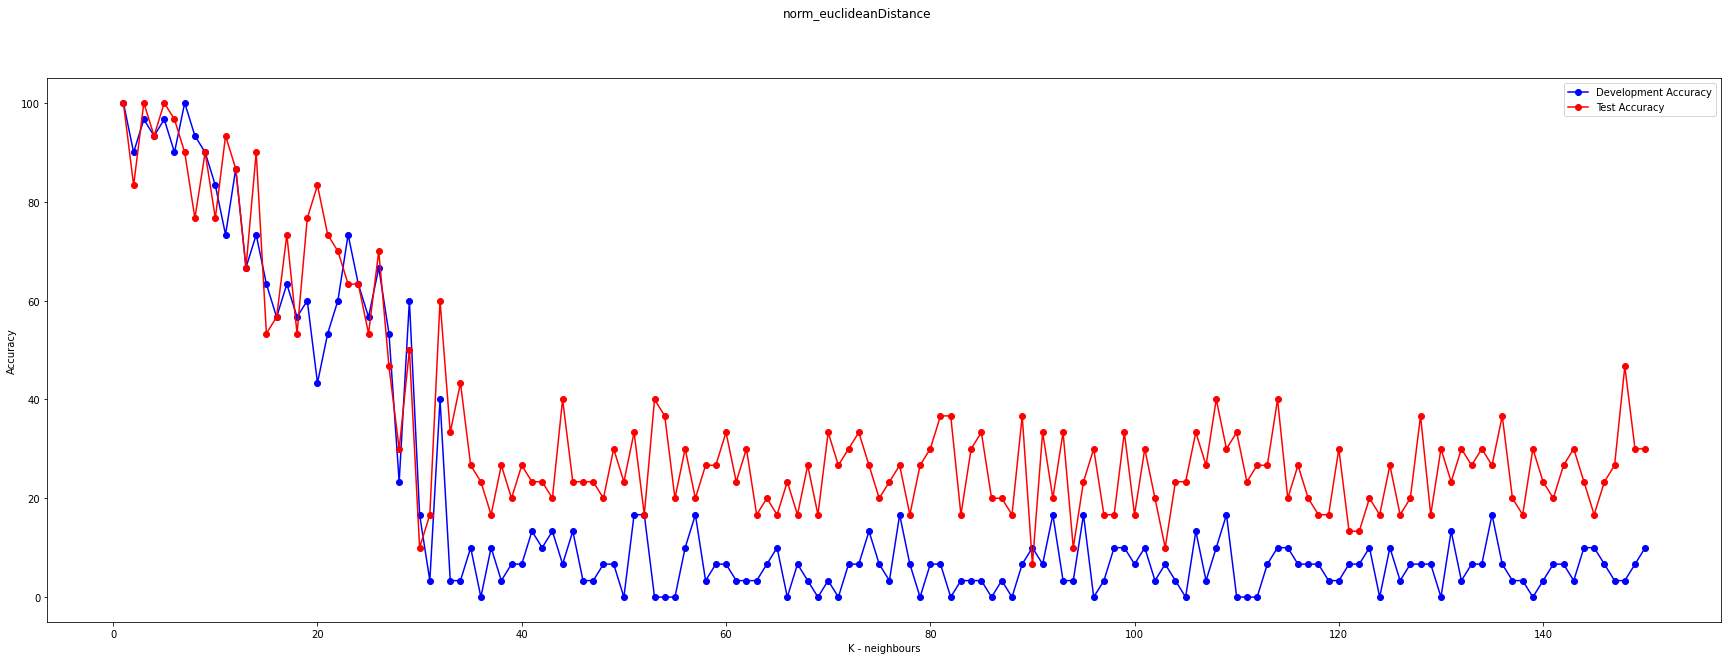

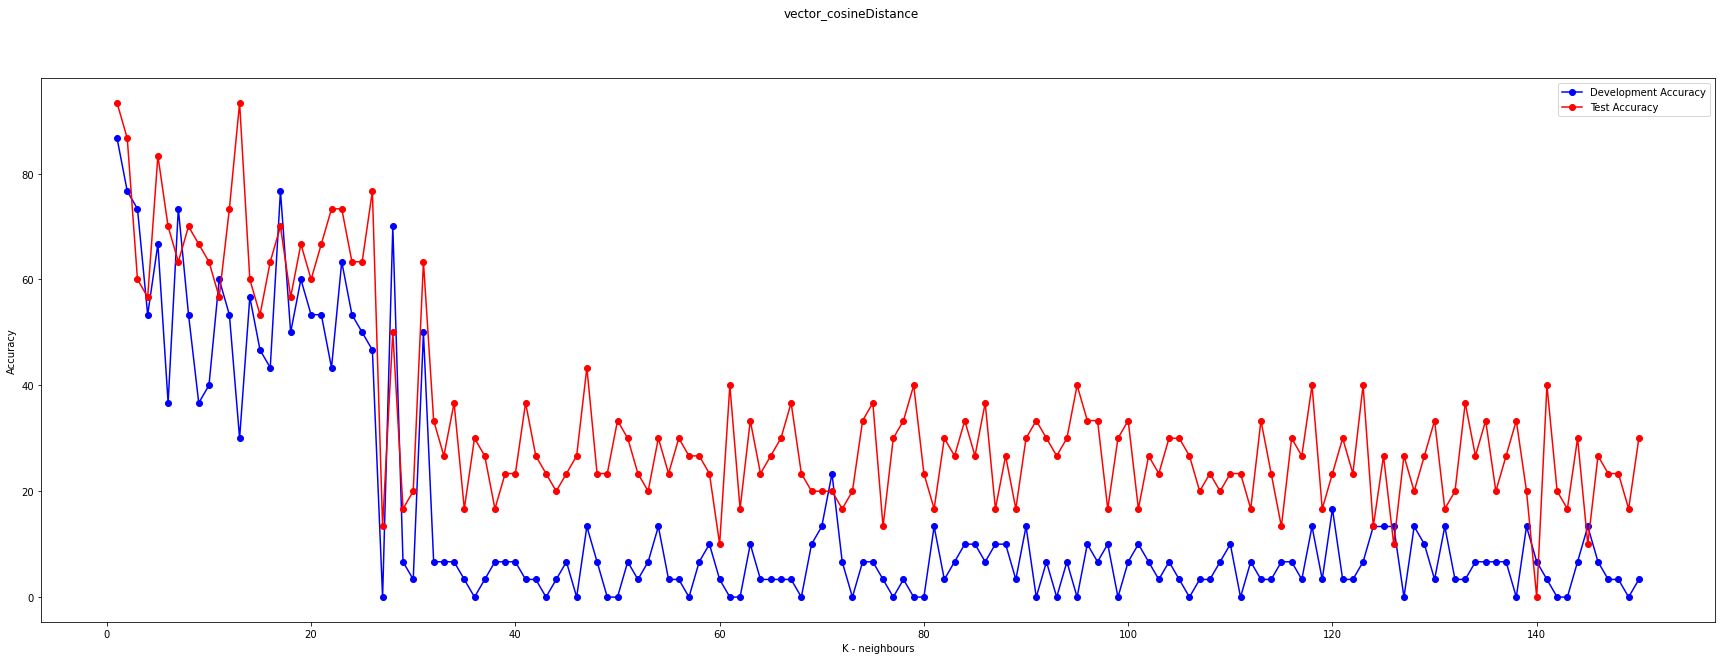

In [11]:
plt.figure(figsize=(30,10))
plt.plot(num_neighbors,dev_score_plot[0:150], 'b-o',label="Development Accuracy")
plt.plot(num_neighbors,test_score_plot[0:150], 'r-o',label="Test Accuracy")
plt.legend(loc="upper right")
plt.xlabel('K - neighbours')
plt.ylabel('Accuracy')
plt.suptitle(distance_metric[0])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(num_neighbors,dev_score_plot[150:300], 'b-o',label="Development Accuracy")
plt.plot(num_neighbors,test_score_plot[150:300], 'r-o',label="Test Accuracy")
plt.legend(loc="upper right")
plt.xlabel('K - neighbours')
plt.ylabel('Accuracy')
plt.suptitle(distance_metric[1])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(num_neighbors,dev_score_plot[300:450], 'b-o',label="Development Accuracy")
plt.plot(num_neighbors,test_score_plot[300:450], 'r-o',label="Test Accuracy")
plt.legend(loc="upper right")
plt.xlabel('K - neighbours')
plt.ylabel('Accuracy')
plt.suptitle(distance_metric[2])
plt.show()

# Conclusion:
- on observing the above graphs we can see that there is a trend of ow accuracy for high number of neighbours for all the three distance metrics namely euclidean distance, normalized euclidean distance, cosine similarity. Hence we can conclude that a k-NN model having **k in the range of 1-10** will provide a **good accuracy in the range of 80-100%**.
- Among the given number of K(1,3,5,7); **K = 1 using different distance metrics outperforms all the others**. But **K= 3 Provides a better fit and almost no difference in the development v/s test accuracy.**

### Accuracy Table:

<table border=3px>
<thead>
<tr>
<th>number of neighbour</th>
<th colspan=2>euclidean distance</th>
<th colspan=2>normalized euclidean distance</th>
<th colspan=2>cosine similarity</th>
</tr>
</thead>
<tbody>
<tr>
<td></td>
<td>Development Accuracy</td>
<td>Test Accuracy</td>
<td>Development Accuracy</td>
<td>Test Accuracy</td>
<td>Development Accuracy</td>
<td>Test Accuracy</td>
</tr>
<tr>
<td>1</td>
<td>96.67%</td>
<td>96.67%</td>
<td>100%</td>
<td>100%</td>
<td>100%</td>
<td>93.33%</td>
</tr>
<tr>
<td>3</td>
<td>93.33%</td>
<td>96.66%</td>
<td>86.67%</td>
<td>90.00%</td>
<td>63.33%</td>
<td>70.00%</td>
</tr>
</tbody>
</table>

# Fold cross validation 

In [12]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = []
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def k_nearest_neighbors_max_count(train, test, num_neighbors,distance_metric):
    predictions = list()
    for row in test:
        output = max_count_makePrediction(train, row, num_neighbors,distance_metric)
        predictions.append(output)
    return predictions

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm_fcv(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset.values.tolist(), n_folds)
    scores = list()
    for i in range(len(folds)):
        temp_set = list(folds)
        test_set = list(temp_set.pop(i))
        train_set = []
        for k in temp_set:
            for r in k:
                train_set.append(r)
        train_set = pd.DataFrame(train_set)
        # drop the class column data of test set
        actual = [row[-1] for row in test_set]
        test_set = pd.DataFrame(test_set)
        test_set = test_set.iloc[:,:-1]
        test_set = test_set.to_numpy()
        test_set = test_set.tolist()
        predicted = (algorithm(train_set, test_set, *args))
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores


# evaluate algorithm
seed(1)
# change the number of folds in FCV
n_folds = 5
# change the number of neighbors in K-NN.
num_neighbors = 5
distance_metric = 'vector_euclideanDistance'
scores = evaluate_algorithm_fcv(data_set, k_nearest_neighbors_max_count, n_folds, num_neighbors,distance_metric)
print(f'Evaluation of {num_neighbors} - Nearest Neighbor(kNN - using max to classify) algorithm using {n_folds} - FCV and {distance_metric} to calculate distance')
print(f'Scores of individual folds:\n{scores}')
#  add a measure of the variance of the skill scores, such as the standard deviation or standard error
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

# change the number of folds in FCV
n_folds = 5
# change the number of neighbors in K-NN.
num_neighbors = 5
distance_metric = 'norm_euclideanDistance'
scores = evaluate_algorithm_fcv(data_set, k_nearest_neighbors_max_count, n_folds, num_neighbors,distance_metric)
print(f'Evaluation of {num_neighbors} - Nearest Neighbor(kNN - using max to classify) algorithm using {n_folds} - FCV {distance_metric} to calculate distance')
print(f'Scores of individual folds:\n{scores}')
#  add a measure of the variance of the skill scores, such as the standard deviation or standard error
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

# change the number of folds in FCV
n_folds = 5
# change the number of neighbors in K-NN.
num_neighbors = 5
distance_metric = 'vector_cosineDistance'
scores = evaluate_algorithm_fcv(data_set, k_nearest_neighbors_max_count, n_folds, num_neighbors,distance_metric)
print(f'Evaluation of {num_neighbors} - Nearest Neighbor(kNN - using max to classify) algorithm using {n_folds} - FCV {distance_metric} to calculate distance')
print(f'Scores of individual folds:\n{scores}')
#  add a measure of the variance of the skill scores, such as the standard deviation or standard error
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Evaluation of 5 - Nearest Neighbor(kNN - using max to classify) algorithm using 5 - FCV and vector_euclideanDistance to calculate distance
Scores of individual folds:
[96.66666666666667, 86.66666666666667, 96.66666666666667, 93.33333333333333, 96.66666666666667]
Mean Accuracy: 94.000%
Evaluation of 5 - Nearest Neighbor(kNN - using max to classify) algorithm using 5 - FCV norm_euclideanDistance to calculate distance
Scores of individual folds:
[83.33333333333334, 100.0, 100.0, 100.0, 90.0]
Mean Accuracy: 94.667%
Evaluation of 5 - Nearest Neighbor(kNN - using max to classify) algorithm using 5 - FCV vector_cosineDistance to calculate distance
Scores of individual folds:
[60.0, 70.0, 70.0, 80.0, 80.0]
Mean Accuracy: 72.000%
